# **DLIP Tutorial - PyTorch**
# CIFAR-10 Classification using PyTorch
Y.-K. Kim
(updated 2022. 5. 6) 

===================

The purpose of this tutorial is to learn how to build a simple CNN model for classification of CIFAR-10

You must do: **Tutorial_PyTorch_MNIST_MLP**  before this tutorial

* Part 1:  Create LeNet5 CNN model and Train/Test with opendataset (CIFAR10)
* Part 2-1:  Create a CNN model(VGG-16) 
* Part 2-2:  Create and Train a CNN model(VGG-16) with opendataset(CIFAR-10)

## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

# Setup Pytorch and Numpy and Device

---




In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 

Using cuda device
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


# Prepare Datasets: 

## Download OpenDataset (CIFAR-10)
Loading OpenDataset (CIFAR-10) from Pytorch data
* ``Dataset``:  stores the samples and their corresponding labels
* ``DataLoader`` wraps an iterable around the ``Dataset``.


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Load CIFAR-10
https://www.cs.toronto.edu/~kriz/cifar.html

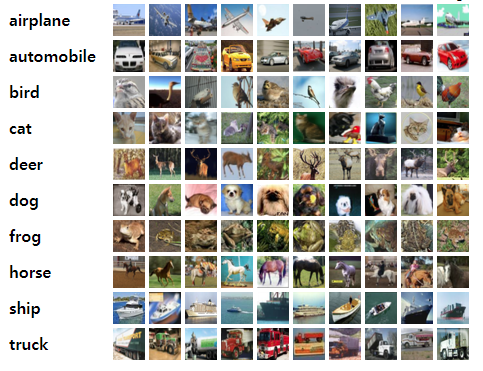

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# torchvision 을 통한 CIFAR10 다운로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,   #converts 0~255 value to 0~1 value.
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")

Files already downloaded and verified
Files already downloaded and verified
train dataset length = 50000
test  dataset length = 10000


## DataLoader
Use  ``DataLoader`` to  make dataset iterable.
* supports automatic batching, sampling, shuffling and multiprocess data loading. 



In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32]) torch.int64
Shape of y: torch.Size([64]) torch.int64


## Visualize training dataset


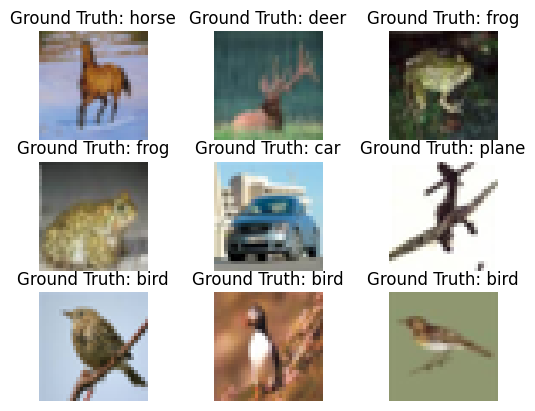

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt

dataiter = iter(train_dataloader)
images, labels = next(iter(train_dataloader))

figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.imshow(np.transpose((images[index] * 0.5 + 0.5).numpy(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

# Define CNN model 

## (Exercise) VGG-16 for CIFAR-10  (Input: 32x32x3)

create a class that inherits from nn.Module


* Define the layers of the network in  __init__ function
* Specify Forward network in the **forward function.**

The original VGG model is created for imagenet dataset.

![VGG16.png](https://user-images.githubusercontent.com/23421059/167051297-fc0f379e-bba9-484e-b223-10349d256985.png)

VGG-16 can be modified for cifar10 (32x32x3 input) as shown below.

#### Architecture detailed (modified to match the input image size)

![](https://user-images.githubusercontent.com/23421059/167058048-fad27ce5-73ff-4c5a-840c-3436818460b2.png)


In [17]:
#########################################################
# [EXERCISE] Create VGG-16 architecture (refer to part1)
#########################################################
class VGG16_cifar10(nn.Module):
    def __init__(self):
        super(VGG16_cifar10, self).__init__()
        
        self.flatten = nn.Flatten()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, padding=1),   #1 
            nn.ReLU(inplace = True),       
            nn.Conv2d(4, 4, kernel_size=3, padding=1),   #1 
            nn.ReLU(inplace = True),   
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(4,8,kernel_size = 3, padding=1),     #3
            nn.ReLU(inplace = True),   
            nn.Conv2d(8,8,kernel_size = 3, padding=1),     #3
            nn.ReLU(inplace = True),   
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(8,16,kernel_size = 3, padding=1),    #5
            nn.ReLU(inplace = True),   
            nn.Conv2d(16,16,kernel_size = 3, padding=1),   #5
            nn.ReLU(inplace = True),   
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(16,32,kernel_size = 3, padding=1),     #7
            nn.ReLU(inplace = True),   
            nn.Conv2d(32,32,kernel_size = 3, padding=1),     #7
            nn.ReLU(inplace = True),
            nn.Conv2d(32,32,kernel_size = 3, padding=1),     #7
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(32,32,kernel_size = 3, padding=1),     #10
            nn.ReLU(inplace = True),
            nn.Conv2d(32,32,kernel_size = 3, padding=1),     #10
            nn.ReLU(inplace = True),
            nn.Conv2d(32,32,kernel_size = 3, padding=1),     #10
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32,32),
            nn.ReLU(inplace=True),
            nn.Linear(32,16),
            nn.ReLU(inplace=True),
            nn.Linear(16,10),
            nn.ReLU(inplace=True),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.flatten(x)
        logit = self.fc_layer(x)
        return logit

model = VGG16_cifar10().to(device)
print(model)

VGG16_cifar10(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_layer): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(16, 32, kernel_size=(3, 3), 

Check your model is valid by **summary()** function


In [18]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             112
              ReLU-2            [-1, 4, 32, 32]               0
            Conv2d-3            [-1, 4, 32, 32]             148
              ReLU-4            [-1, 4, 32, 32]               0
         MaxPool2d-5            [-1, 4, 16, 16]               0
            Conv2d-6            [-1, 8, 16, 16]             296
              ReLU-7            [-1, 8, 16, 16]               0
            Conv2d-8            [-1, 8, 16, 16]             584
              ReLU-9            [-1, 8, 16, 16]               0
        MaxPool2d-10              [-1, 8, 8, 8]               0
           Conv2d-11             [-1, 16, 8, 8]           1,168
             ReLU-12             [-1, 16, 8, 8]               0
           Conv2d-13             [-1, 16, 8, 8]           2,320
             ReLU-14             [-1, 1

# Optimization Setup  

## Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

## Loss function

Cross entropy for Classification

In [19]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train and Test the model

## Train the model
### Define **train()** function 


In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


## Test the model

### Define **test()** function 
Using ``eval()`` for test. Evaluate mode로 전환

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_pred=pred.argmax(1);
            test_loss += loss_fn(pred, y).item()
            correct += (y_pred == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Optimizing the Model Parameters

In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307809  [    0/50000]
loss: 2.305549  [ 6400/50000]
loss: 2.310608  [12800/50000]
loss: 2.251675  [19200/50000]
loss: 2.063498  [25600/50000]
loss: 2.218312  [32000/50000]
loss: 2.117322  [38400/50000]
loss: 2.074923  [44800/50000]
Test Error: 
 Accuracy: 23.6%, Avg loss: 2.103843 

Epoch 2
-------------------------------
loss: 2.074523  [    0/50000]
loss: 2.015250  [ 6400/50000]
loss: 2.187440  [12800/50000]
loss: 2.046565  [19200/50000]
loss: 1.899941  [25600/50000]
loss: 2.039733  [32000/50000]
loss: 2.229846  [38400/50000]
loss: 1.967464  [44800/50000]
Test Error: 
 Accuracy: 30.9%, Avg loss: 1.982947 

Epoch 3
-------------------------------
loss: 1.994708  [    0/50000]
loss: 2.056789  [ 6400/50000]
loss: 1.986259  [12800/50000]
loss: 2.030834  [19200/50000]
loss: 2.000932  [25600/50000]
loss: 1.776098  [32000/50000]
loss: 1.985359  [38400/50000]
loss: 1.832292  [44800/50000]
Test Error: 
 Accuracy: 34.8%, Avg loss: 1.822995 

Epoc

# Visualize test results

Select random test images and evaluate

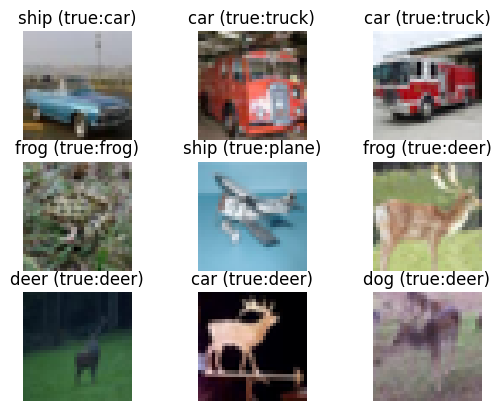

In [13]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(iter(test_dataloader))

images = images.to(device)
labels = labels.to(device)

# Evaluate mode
# Prediction of some sample images 
with torch.no_grad():
    pred = model(images)
    _, predicted = torch.max(pred.data, 1);

figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.5 + 0.5).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

# Saving Models
* save the structure of this class together with the model

In [14]:
torch.save(model,"trained_VGG16(CIFAR10).pth")